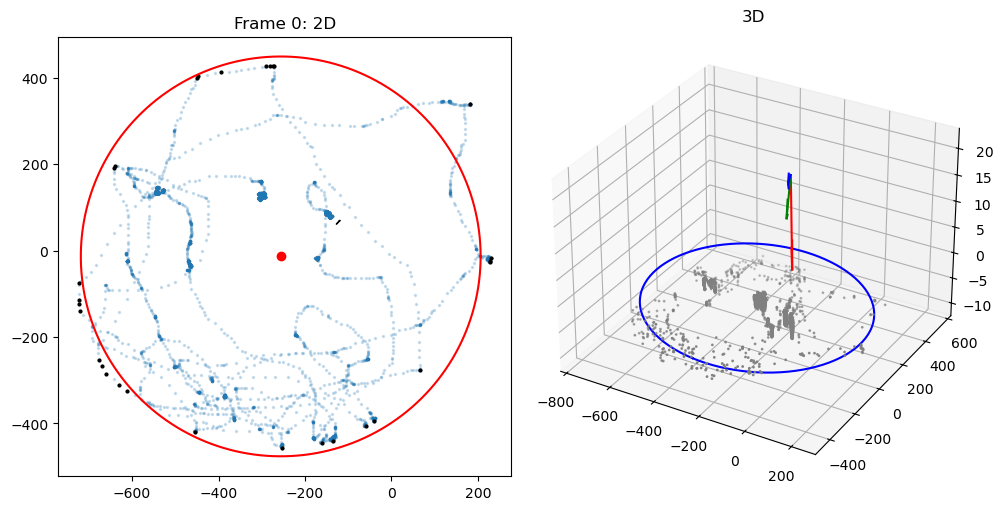

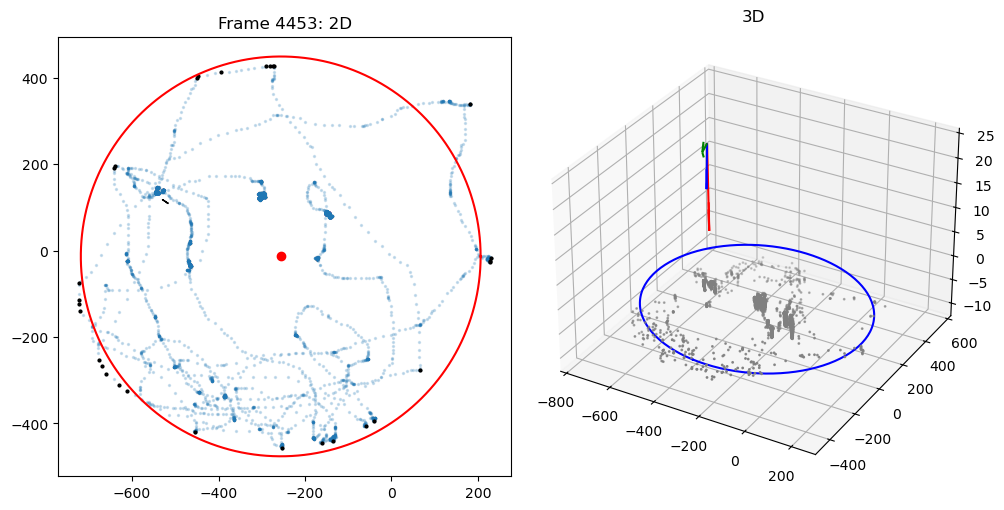

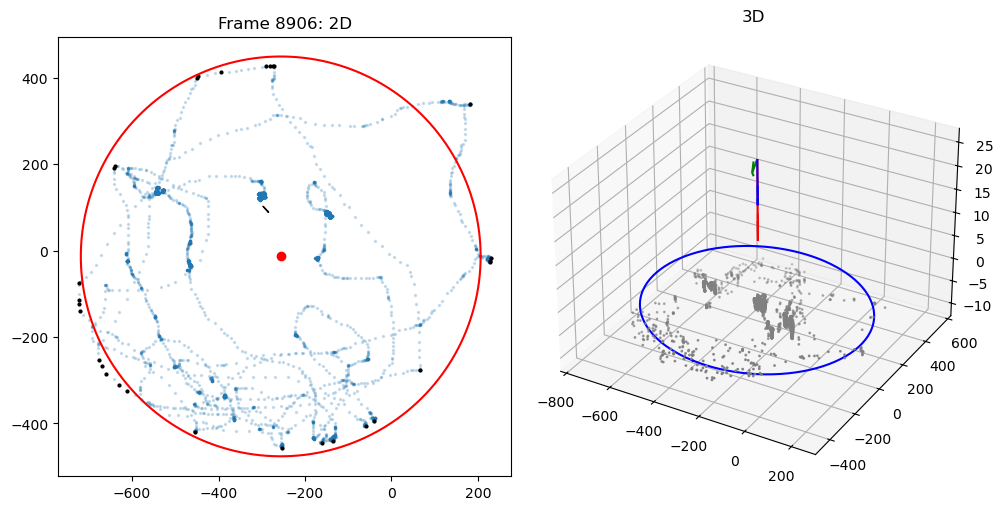

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import least_squares
from scipy.spatial import ConvexHull
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Load HDF5 with selection logic ---
def select_h5(rec_path):
    rec = Path(rec_path)
    pths = list((rec/"MIR_Aligned").glob("aligned_predictions_with_ca_and_dF_F*.h5"))
    if not pths:
        raise FileNotFoundError(f"No .h5 in {rec/'MIR_Aligned'}")
    return pths[0] if len(pths)==1 else max(pths, key=lambda p: len(p.stem))

hdf5_path = select_h5("/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37")
df = pd.read_hdf(hdf5_path, key='df')
nframes = len(df)

# --- 2. Fit circle to COM x,y ---
x = df['com_x'].to_numpy()
y = df['com_y'].to_numpy()
pts = np.column_stack((x,y))
hull = ConvexHull(pts)
hx, hy = pts[hull.vertices].T

def resid(p, x,y):
    return np.hypot(x-p[0], y-p[1]) - p[2]

# compute an initial center
cx0, cy0 = hx.mean(), hy.mean()
# initial radius: average distance from hull points to that center
r0 = np.mean(np.hypot(hx - cx0, hy - cy0))

# now call least_squares
res = least_squares(resid, [cx0, cy0, r0], args=(hx, hy))
xc, yc, r = res.x

xc, yc, r = res.x
theta = np.linspace(0,2*np.pi,200)
circ_xy = np.vstack((xc + r*np.cos(theta), yc + r*np.sin(theta))).T

# --- 3. Fit plane to candidate paw points ---
paw_idxs = [17,20]  # HindpawL, HindpawR
cand = []
thr = 5.0
for idx in paw_idxs:
    zs = df[f'kp{idx}_z'].to_numpy()
    mn = zs.min()
    mask = zs <= mn+thr
    cand.append(np.vstack((df[f'kp{idx}_x'][mask],
                           df[f'kp{idx}_y'][mask],
                           zs[mask])).T)
cand = np.vstack(cand)
C = cand.mean(axis=0)
U,S,Vt = np.linalg.svd(cand - C)
nrm = Vt[-1]
if nrm[2]<0: nrm = -nrm

# plane_basis for projection
def basis(n):
    v = np.array([1,0,0]) if abs(n[0])<1e-3 else np.array([0,0,1])
    b1 = np.cross(n,v); b1/=np.linalg.norm(b1)
    b2 = np.cross(n,b1); b2/=np.linalg.norm(b2)
    return b1,b2

b1,b2 = basis(nrm)
# project circle onto plane in 3D
circ3d = np.array([C + r*(np.cos(t)*b1 + np.sin(t)*b2) for t in theta])

# --- 4. Head‐orientation frame for a given row ---
def head_frame(row):
    eL = np.array([row.kp1_x,row.kp1_y,row.kp1_z])
    eR = np.array([row.kp2_x,row.kp2_y,row.kp2_z])
    sn = np.array([row.kp3_x,row.kp3_y,row.kp3_z])
    mid = (eL+eR)/2
    xh = (sn-mid); xh/=np.linalg.norm(xh)
    ty = eR-eL
    yh = ty - xh*(xh.dot(ty)); yh/=np.linalg.norm(yh)
    zh = np.cross(xh,yh)
    return mid, np.column_stack((xh,yh,zh))

# --- 5. Plot function ---
def plot_frame(i):
    row = df.iloc[i]
    mid, R_head = head_frame(row)
    # pick head x-axis as "gaze"
    gaze = R_head[:,0]

    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.scatter(x,y, s=2, alpha=0.2)
    ax1.plot(hx,hy,'k.',ms=4)
    ax1.plot(circ_xy[:,0], circ_xy[:,1],'r-')
    ax1.scatter([xc],[yc],c='r')
    # draw gaze vector projected to table plane at head_mid
    # find intersection with table plane:
    t = (C[2]-mid[2])/(gaze[2])
    p = mid + gaze*t
    ax1.arrow(mid[0],mid[1], p[0]-mid[0], p[1]-mid[1],
              head_width=2, length_includes_head=True)
    ax1.set_aspect('equal'); ax1.set_title(f"Frame {i}: 2D")

    ax2 = fig.add_subplot(1,2,2, projection='3d')
    ax2.scatter(cand[:,0],cand[:,1],cand[:,2],c='gray',s=1)
    ax2.plot_surface(*np.meshgrid([C[0]],[C[1]]), np.array([[C[2]]]), alpha=0.3)
    ax2.plot(circ3d[:,0],circ3d[:,1],circ3d[:,2],'b-')
    # head axes
    for v,col in zip(R_head.T,('r','g','b')):
        ax2.quiver(mid[0],mid[1],mid[2],*v,length=20, color=col)
    ax2.set_title("3D"); 
    plt.tight_layout()
    plt.show()

# --- 6. Render first, middle, last frames ---
for idx in [0, nframes//2, nframes-1]:
    plot_frame(idx)
